In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

100%|██████████| 74/74 [00:00<00:00, 157.28it/s]


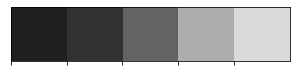

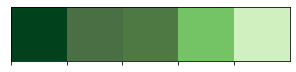

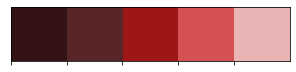

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
X_train = []
y_train = []
image_size = 128
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('C:\\Users\\Shrey\\MinorProjectDB','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('C:\\Users\\Shrey\\MinorProjectDB','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [4]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
from tensorflow.keras.applications import ResNet152V2
resnet = ResNet152V2(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

In [6]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [9]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet152v1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [10]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =9, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

C:\Users\Shrey\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/9
83/83 [==============================] - 727s 9s/step - loss: 0.8214 - accuracy: 0.6947 - val_loss: 246.8193 - val_accuracy: 0.1531

Epoch 00001: val_accuracy improved from -inf to 0.15306, saving model to resnet152v1.h5
Epoch 2/9
83/83 [==============================] - 723s 9s/step - loss: 0.4480 - accuracy: 0.8483 - val_loss: 1.8941 - val_accuracy: 0.5306

Epoch 00002: val_accuracy improved from 0.15306 to 0.53061, saving model to resnet152v1.h5
Epoch 3/9
83/83 [==============================] - 724s 9s/step - loss: 0.3399 - accuracy: 0.8789 - val_loss: 3.2913 - val_accuracy: 0.4830

Epoch 00003: val_accuracy did not improve from 0.53061
Epoch 4/9
83/83 [==============================] - 710s 9s/step - loss: 0.2674 - accuracy: 0.9103 - val_loss: 0.5420 - val_accuracy: 0.8537

Epoch 00004: val_accuracy improved from 0.53061 to 0.85374, saving model to resnet152v1.h5
Epoch 5/9
83/83 [==============================] - 696s 8s/step - loss: 0.1736 - accuracy: 0.9414 - val_loss:

In [11]:
train_dir = "C:\\Users\\Shrey\\MinorProjectDB\\Training"
test_dir = "C:\\Users\\Shrey\\MinorProjectDB\\Testing"

In [12]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(128,128),
                                                                 label_mode = "categorical",
                                                                 batch_size = 32
                                                                 )
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size =(128,128),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [13]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [14]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        93
           1       0.69      0.96      0.80        51
           2       0.90      0.81      0.85        96
           3       0.94      0.94      0.94        87

    accuracy                           0.87       327
   macro avg       0.87      0.89      0.87       327
weighted avg       0.89      0.87      0.88       327



C:\Users\Shrey\AppData\Local\Temp/ipykernel_8736/3854475971.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


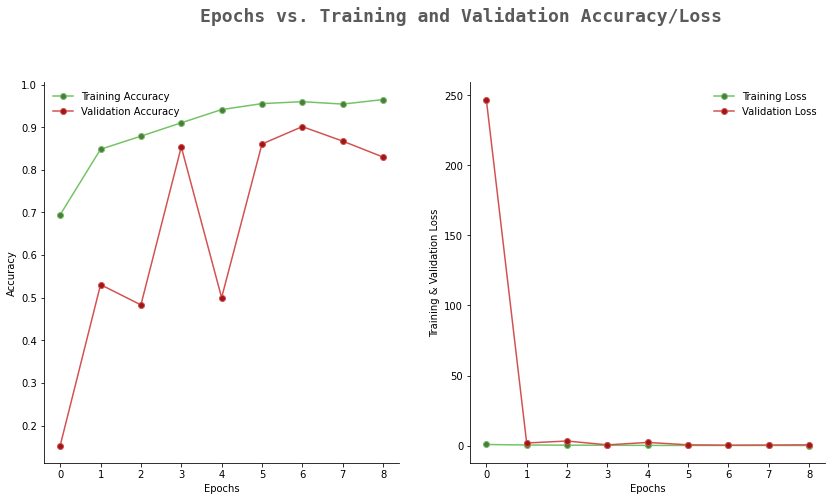

In [15]:
epochs = [i for i in range(9)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()